##### **Before starting ...**

Checking we are using **frugal-notebooks-env** conda environment

In [2]:
!which python

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/bin/python


Checking the python version is 3.9 (compatibility with frugal AI codebase)

In [3]:
!python --version

Python 3.9.21


# XGBoost

## 1. **Dataset Exploration**

In [4]:
import numpy as np
import pandas as pd

**Loading the dataset**

In [5]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

In [6]:
df.head()

,quote,label,source,url,language,subsource,id
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None


**We will only use the quote and label columns**

In [7]:
df.columns

Index(['quote', 'label', 'source', 'url', 'language', 'subsource', 'id'], dtype='object')

In [8]:
df = df[['quote', 'label']]
df.head()

,quote,label
0,"There is clear, compelling evidence that many ...",5_science_unreliable
1,"For most of the Holocene (last 10k years), sea...",1_not_happening
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant
4,It's going to be 42 here today and the hottest...,1_not_happening


**The label have 8 classes**

In [9]:
print('unique values:')
print('label\n', df['label'].unique())

unique values:
label
 ['5_science_unreliable' '1_not_happening'
 '4_solutions_harmful_unnecessary' '0_not_relevant' '6_proponents_biased'
 '7_fossil_fuels_needed' '2_not_human' '3_not_bad']


**No duplicate quotes**

In [10]:
df['quote'].duplicated().sum()

0

**But we have a bit of unbalanced classes (that we will have to take care of)**

In [11]:
class_distribution = df['label'].value_counts().sort_index()
df['label'].value_counts(normalize=True).sort_index()

label
0_not_relevant                     0.265638
1_not_happening                    0.121655
2_not_human                        0.115252
3_not_bad                          0.063372
4_solutions_harmful_unnecessary    0.127073
5_science_unreliable               0.131505
6_proponents_biased                0.128386
7_fossil_fuels_needed              0.047119
Name: proportion, dtype: float64

In [12]:
import plotly.express as px

fig = px.bar(x=class_distribution.index, y=class_distribution.values, 
             labels={'x': 'Label', 'y': 'Count'})
fig.update_layout(width=900, height=400, title="Class Distribution")
fig.show(renderer='iframe')

**No missing values**

In [13]:
missing_values = df.isnull().sum()
print(missing_values)

quote    0
label    0
dtype: int64


**We will need to crop some quotes**

In [14]:
df['text_length'] = df['quote'].str.len()
print(df['text_length'].describe())

count    6091.000000
mean      293.528485
std       258.330755
min        19.000000
25%       139.000000
50%       228.000000
75%       365.000000
max      4703.000000
Name: text_length, dtype: float64


In [15]:
fig = px.histogram(df, x='text_length', nbins=50)
fig.update_layout(width=800, height=300, title="Sentence Length Distribution")
fig.show(renderer='iframe')

In [16]:
threshold = np.percentile(df['text_length'], 95)
threshold

722.5

In [17]:
long_quotes = df[df['text_length'] > threshold]
print('Number of quotes above threshold: ', long_quotes.shape[0])

Number of quotes above threshold:  305


## **2. Preprocessing**

### **Features and target**

In [18]:
X = df['quote']
y = df['label']
X.shape, y.shape

((6091,), (6091,))

In [19]:
def print_head(df):
    for i in range(3):
        print(i, df[i], '\n')
    print('shape:',df.shape)

### **Cleaning**

In [20]:
import string
import re
import contractions
import html
import unicodedata
from wordsegment import load, segment

load()

def segment_unseparated(sentence, threshold=20):
    return " ".join(
        word if len(word) > threshold else " ".join(segment(word))
        for word in sentence.split()
    )
 
def basic_cleaning(sentence:str, threshold:int=15):
    sentence = html.unescape(sentence)                        # convert html entities
    sentence = re.sub(r'http\S+|www\S+', '', sentence)        # remove URLs
    sentence = unicodedata.normalize('NFKC', sentence)        # normalize Unicode
    sentence = sentence.encode("ascii", "ignore").decode()    # remove non ASCII
    sentence = contractions.fix(sentence)                     # expand contractions
    sentence = sentence.lower()                               # lowercase
    sentence = re.sub(r'\d+', '', sentence)                   # remove digits
    punctuation = string.punctuation.replace("-", "")         # keep hyphens
    translator = str.maketrans('', '', punctuation)
    sentence = sentence.translate(translator)                 # remove punctuation
    sentence = re.sub(r'\s-\s', ' ', sentence)                # removes " - " (hyphen surrounded by spaces)
    sentence = re.sub(r'\s-', ' ', sentence)                  # removes leading hyphens
    sentence = re.sub(r'-\s', ' ', sentence)                  # removes trailing hyphens
    sentence = segment_unseparated(sentence, threshold=threshold) # separate words that should be separated
    sentence = ' '.join(sentence.split()).strip()             # remove whitespace
    return sentence

In [21]:
X_clean = X.apply(basic_cleaning)
#print_head(X_clean)

### **Preprocessing**
- tokenize
- stopwords
- lemmatize
- crop sentence lenght
- rejoin

In [22]:
def preproc(sentence, threshold=750):
    tokens = word_tokenize(sentence)
    tokens = [w for w in tokens if w.lower() not in stop_words]              # remove stop_words
    tokens = [WordNetLemmatizer().lemmatize(w, pos = "v") for w in tokens]   # lemmatize
    tokens = tokens[:threshold]
    return " ".join(tokens)

#### **Details**

**Tokenizing**

In [23]:
import nltk
from nltk.tokenize import word_tokenize

In [24]:
# nltk_path = "/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/nltk_data"
# nltk.download('punkt_tab', download_dir=nltk_path)

In [25]:
X_tokenized = X_clean.apply(word_tokenize)
# print_head(X_tokenized)

**Stopwords**

In [26]:
from nltk.corpus import stopwords

# nltk.download('stopwords', download_dir=nltk_path)
stop_words = set(stopwords.words('english'))

In [27]:
def remove_stopwords(sentence):
    return [w for w in sentence if w.lower() not in stop_words]

X_stopwords = X_tokenized.apply(remove_stopwords)

# print_head(X_stopwords)

**Lemmatizing**

In [28]:
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet', download_dir=nltk_path)

In [29]:
def lemmatize_tokens(sentence):
    return " ".join([WordNetLemmatizer().lemmatize(w, pos = "v") for w in sentence])


X_lemmatized = X_stopwords.apply(lemmatize_tokens)
# print_head(X_lemmatized)

**Crop quote lenght**

In [30]:
def crop_tokens(tokens, threshold=750):
    return tokens[:threshold]

X_cropped = X_lemmatized.apply(crop_tokens)
# print_head(X_cropped)

**Rejoin sentence**

In [31]:
def rejoin(words):
    return "".join(words)

X_lemmatized_text = X_cropped.apply(rejoin)
# print_head(X_lemmatized_text)

### **Vectorizing**

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_vectorized = pd.DataFrame(
    vectorizer.fit_transform(X_lemmatized_text).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_lemmatized.index
)

vocabulary = vectorizer.get_feature_names_out()

word_occurrences = (X_vectorized > 0).sum(axis=0)
word_count = dict(zip(vocabulary, np.asarray(word_occurrences).flatten()))

print(f"\nVocabulary size: {len(vocabulary)}")
print()

from nltk.corpus import words
english_vocab = set(words.words())
oov_words = [word for word in vocabulary if word.lower() not in english_vocab]
print(f"Out-of-vocabulary words: {len(oov_words)}")
# X_vectorized.head(3)
# print('feature shape:', X_vectorized.shape)


Vocabulary size: 12103

Out-of-vocabulary words: 3862


### **Checking quality of preprocessing**

In [33]:
# non alphanum 
alphanum_error = [word for word in vocabulary if re.search(r"[^a-zA-Z0-9'-]", word)]
print("preprocessing alphanum errors:", alphanum_error[:20])
print('---------------')

# case-sensitive duplicates
vocab_lower = set(word.lower() for word in vocabulary)
if len(vocab_lower) != len(vocabulary):
    print("Warning: Vocabulary contains case-sensitive duplicates!")
print('---------------')

# short words and long words
short_words = [word for word in vocabulary if len(word) <= 2]
long_words = [word for word in vocabulary if len(word) > 15]

print('Longest and shortest words:')
print(len(short_words), "short words (≤2 chars):\n", short_words[:20])
print(len(long_words), "long words (>15 chars):\n", long_words[:20])
print('---------------')

# most / least frequent
from collections import Counter

word_count_counter = Counter(word_count)
print("Most common words:\n", word_count_counter.most_common(10))
print("Least common words:\n", word_count_counter.most_common()[-10:])
print('---------------')

# out of vocabulary - not english
#nltk.download('words', download_dir=nltk_path)
from nltk.corpus import words

english_vocab = set(words.words())

oov_words = [word for word in vocabulary if word.lower() not in english_vocab]
print(f"Out-of-vocabulary words: {len(oov_words)}")
print("Sample OOV words:", oov_words[:20])
print('---------------')

preprocessing alphanum errors: []
---------------
---------------
Longest and shortest words:
210 short words (≤2 chars):
 ['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ak', 'al', 'ao', 'ap', 'ar', 'as', 'au', 'ax', 'az', 'ba', 'bc', 'be']
118 long words (>15 chars):
 ['absorptionemission', 'absorptivitiesemissivities', 'absorptivityemissivity', 'administrationand', 'administrationto', 'americansespecially', 'americaspowercom', 'americatraditional', 'antidiscrimination', 'antienvironmental', 'authoritarianism', 'baltimorewashington', 'bureaucratically', 'carefullyselected', 'catastrophically', 'centerdeveloping', 'changedismissing', 'characterization', 'characterizations', 'chlorflourocarbon']
---------------
Most common words:
 [('climate', 2201), ('change', 1596), ('warm', 1334), ('global', 1283), ('years', 702), ('say', 688), ('carbon', 657), ('would', 646), ('energy', 643), ('make', 603)]
Least common words:
 [('zeller', 1), ('zi', 1), ('zing', 1), ('zinke', 1), ('zipper', 1), 

In [34]:
long_words = [word for word in vocabulary if len(word) > 15 and len(word) < 20]
test_df = pd.DataFrame({
    'word' : long_words, 
    'length': [len(word) for word in long_words],
    'separated' : [segment_unseparated(word) for word in long_words]
} )
#test_df.sort_values(by='length', ascending=False)


**Let's have a look at the most frequent words**

In [35]:
#word_count_counter

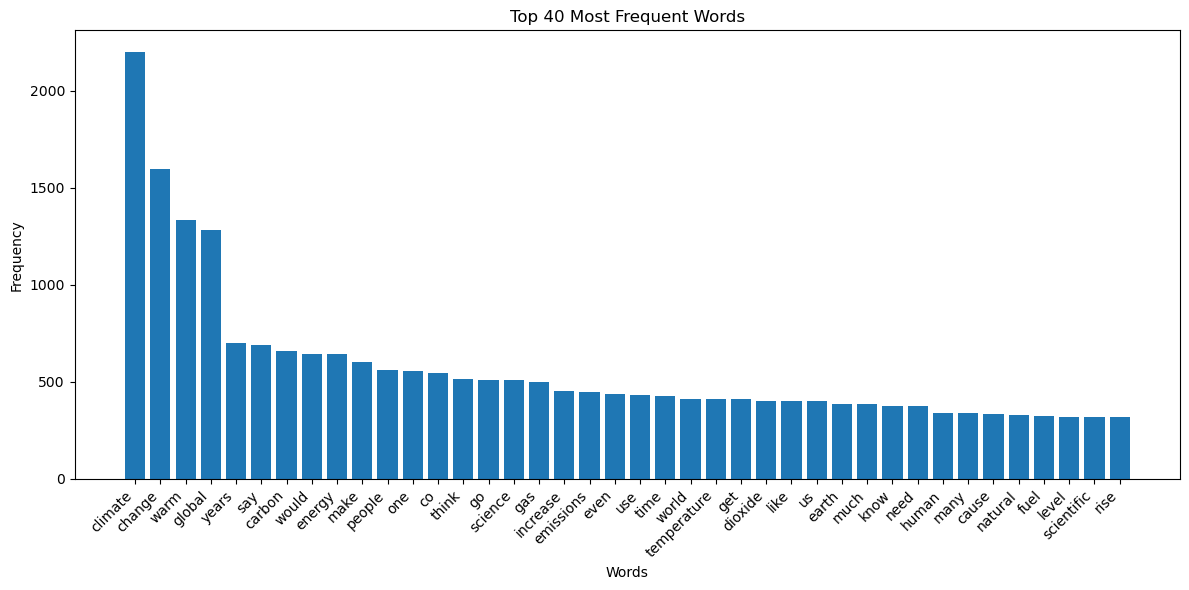


Total words: 139036
Unique words: 12103
Average word frequency: 11.49




In [36]:
import matplotlib.pyplot as plt

top_20_words = word_count_counter.most_common(40)
df_word_freq = pd.DataFrame(top_20_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.bar(df_word_freq['Word'], df_word_freq['Frequency'])
plt.title('Top 40 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

total_words = sum(word_count_counter.values())
unique_words = len(vocabulary)
average_freq = total_words / unique_words

print(f"\nTotal words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Average word frequency: {average_freq:.2f}")
print()
print()

### **Encode target**

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_cat = le.fit_transform(y)
print(le.classes_)
print()
print('y_cat :', y_cat)

['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']

y_cat : [5 1 4 ... 0 5 1]


## **3. Baseline**

### **Feature and target**

In [38]:
X_vectorized

,aa,ab,abandon,abandoned,abandonment,abate,abatement,abbot,abbott,abc,...,zika,zing,zinke,zipper,zir,zone,zoom,zoonotic,zurich,zycher
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
y_cat

array([5, 1, 4, ..., 0, 5, 1])

In [40]:
X_vectorized.shape, y_cat.shape, type(X_vectorized), type(y_cat)

((6091, 12103), (6091,), pandas.core.frame.DataFrame, numpy.ndarray)

**Train test split**

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

print('types', type(X_train), type(X_test), type(y_train), type(y_test))
'Shapes', X_train.shape, X_test.shape, y_train.shape, y_test.shape

types <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


('Shapes', (4872, 12103), (1219, 12103), (4872,), (1219,))

### **Resampling for unbalanced classes**

In [42]:
print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_train).value_counts())

0    0.265599
5    0.131568
6    0.128284
4    0.127053
1    0.121716
2    0.115148
3    0.063424
7    0.047209
Name: proportion, dtype: float64
0    1294
5     641
6     625
4     619
1     593
2     561
3     309
7     230
Name: count, dtype: int64


In [43]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

def resampling(X, y):
    y = pd.Series(y)
    
    mean_count = int(max(y.value_counts()) / 2)
    smote_strategy = {
        label: mean_count if count < mean_count else count 
        for label, count in y.value_counts().items()
    }
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    undersample_strategy = {label: mean_count for label in y.value_counts().keys()}
    undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
    X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

    return X_resampled, y_resampled

X_train, y_train = resampling(X_train, y_train)

print(pd.Series(y_train).value_counts(normalize=False))

0    647
1    647
2    647
3    647
4    647
5    647
6    647
7    647
Name: count, dtype: int64


**Check the category split**

In [44]:
total_category_counts = pd.DataFrame(y).value_counts().sort_index()
train_category_counts = pd.DataFrame(y_train).value_counts().sort_index()
test_category_counts = pd.DataFrame(y_test).value_counts().sort_index()

total_proportions = pd.DataFrame(y).value_counts(normalize=True).sort_index().round(2)
train_proportions = pd.DataFrame(y_train).value_counts(normalize=True).sort_index().round(2)
test_proportions = pd.DataFrame(y_test).value_counts(normalize=True).sort_index().round(2)

category_distribution_df = pd.DataFrame({
    "total": total_category_counts.values,
    "train": train_category_counts.values,
    "test": test_category_counts.values,
    "total%": total_proportions.values,
    "train%": train_proportions.values,
    "test%": test_proportions.values
}, index=total_category_counts.index)

print(category_distribution_df)

                                 total  train  test  total%  train%  test%
label                                                                     
0_not_relevant                    1618    647   324    0.27    0.12   0.27
1_not_happening                    741    647   148    0.12    0.12   0.12
2_not_human                        702    647   141    0.12    0.12   0.12
3_not_bad                          386    647    77    0.06    0.12   0.06
4_solutions_harmful_unnecessary    774    647   155    0.13    0.12   0.13
5_science_unreliable               801    647   160    0.13    0.12   0.13
6_proponents_biased                782    647   157    0.13    0.12   0.13
7_fossil_fuels_needed              287    647    57    0.05    0.12   0.05


### **Model : XGBoost**

In [45]:
import xgboost as xgb

baseline_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

**Baseline : Cross validation**

In [46]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_accuracy = cross_val_score(baseline_model, X_train, y_train, cv=skf).mean()

print("Baseline")
print(f"Cross-validation accuracy on 5 folds: {round(baseline_accuracy, 2)}")

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:49:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used

Baseline
Cross-validation accuracy on 5 folds: 0.67


## 5. **Efficiency metrics : Tracking energy consumption**

### **During training**

In [46]:
X_train.shape, y_train.shape

((5176, 12103), (5176,))

In [47]:
from codecarbon import EmissionsTracker

def monitor_training(model, X_train, y_train):
    tracker = EmissionsTracker(log_level="error")
    tracker.start()

    model.fit(X_train, y_train)

    training_emissions = tracker.stop()
    training_time = tracker.final_emissions_data.duration
    training_energy_conso = tracker.final_emissions_data.energy_consumed

    train_efficiency_metrics = {
        "total_latency_sec": training_time,
        "sample_latency_sec": training_time / X_train.shape[0],
        "total_energy_conso_kWh": training_energy_conso,
        "sample_energy_conso_kWh": training_energy_conso / X_train.shape[0],
        "total_emissions_kgCO₂eq": training_emissions,
#        "tracker_data": tracker.final_emissions_data
    }
    train_efficiency_metrics_df = pd.DataFrame.from_dict(train_efficiency_metrics, columns=['metrics'], orient='index')

    return model, train_efficiency_metrics_df

baseline_model, train_efficiency_metrics_df = monitor_training(baseline_model, X_train, y_train)

print(train_efficiency_metrics_df)
print()

                              metrics
total_latency_sec        1.989603e-01
sample_latency_sec       3.843901e-05
total_energy_conso_kWh   2.845615e-06
sample_energy_conso_kWh  5.497711e-10
total_emissions_kgCO₂eq  1.651424e-07



### **During inference**

In [48]:
X_test.shape

(1219, 12103)

In [49]:
from codecarbon import EmissionsTracker

def monitor_inference(model, X_test):
    tracker = EmissionsTracker(log_level="error")
    tracker.start()
    
    y_pred = model.predict(X_test)

    inference_emissions = tracker.stop()
    inference_time = tracker.final_emissions_data.duration
    inference_energy_conso = tracker.final_emissions_data.energy_consumed

    inf_efficiency_metrics = {
        "total_latency_sec": inference_time,
        "sample_latency_sec": inference_time / X_test.shape[0],
        "total_energy_conso_kWh": inference_energy_conso,
        "sample_energy_conso_kWh": inference_energy_conso / X_test.shape[0],
        "total_emissions_kgCO₂eq": inference_emissions,
#        "tracker_data": tracker.final_emissions_data
    }
    inf_efficiency_metrics_df = pd.DataFrame.from_dict(inf_efficiency_metrics, columns=['metrics'], orient='index')

    return y_pred, inf_efficiency_metrics_df

y_pred, inf_efficiency_metrics_df = monitor_inference(baseline_model, X_test)

print(inf_efficiency_metrics_df)
print()

                              metrics
total_latency_sec        6.663823e-02
sample_latency_sec       5.466631e-05
total_energy_conso_kWh   9.525356e-07
sample_energy_conso_kWh  7.814074e-10
total_emissions_kgCO₂eq  5.527945e-08



### **Summary table**

In [50]:
df_combined = pd.concat([train_efficiency_metrics_df, inf_efficiency_metrics_df], axis=1)
df_combined.columns = ['training', 'inference']
df_combined

,training,inference
total_latency_sec,1.989603e-01,6.663823e-02
sample_latency_sec,3.843901e-05,5.466631e-05
total_energy_conso_kWh,2.845615e-06,9.525356e-07
sample_energy_conso_kWh,5.497711e-10,7.814074e-10
total_emissions_kgCO₂eq,1.651424e-07,5.527945e-08


## 4. **Performance metrics**

**Metrics**  
evaluation with :  
- accuracy  

monitor:  
- class_accuracy
- precision
- recall
- f1

### **functions**

**compute metrics**

In [51]:
y_test.shape, y_pred.shape

((1219,), (1219,))

In [52]:
np.unique(y_test), np.unique(y_pred)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7]))

In [53]:
from sklearn.metrics import accuracy_score     # tp + tn / all  : maximize correct predictions
from sklearn.metrics import precision_score    # tp / (tp + fp) : minimize false positives
from sklearn.metrics import recall_score       # tp / (tp + fn) : maximize true positives
from sklearn.metrics import f1_score           # harmonic mean of the precision and recall

def compute_class_accuracy(y_test, y_pred):
    df = pd.DataFrame({'label': y_test, 'correct': y_test == y_pred})
    return df.groupby('label')['correct'].mean()

def evaluation(y_test, y_pred):    
    accuracy = accuracy_score(y_test, y_pred)

    labels = np.unique(y_pred)
    class_accuracy = compute_class_accuracy(y_test, y_pred)
    class_precision = precision_score(y_test, y_pred, average=None, labels=labels)
    class_recall = recall_score(y_test, y_pred, average=None, labels=labels)
    class_f1 = f1_score(y_test, y_pred, average=None, labels=labels)

    eval_perf_metrics_df = pd.DataFrame({
        "Category": labels,
        "Accuracy": class_accuracy.values,
        "Precision": class_precision,
        "Recall": class_recall,
        "F1 Score": class_f1
    })

    return accuracy, eval_perf_metrics_df

baseline_test_accuracy, eval_perf_metrics_df = evaluation(y_test, y_pred)

print('\nBaseline Test accuracy:', round(baseline_test_accuracy, 3), '\n')
print('Class metrics:\n')
eval_perf_metrics_df.round(2)


Baseline Test accuracy: 0.561 

Class metrics:



,Category,Accuracy,Precision,Recall,F1 Score
0,0,0.33,0.86,0.33,0.47
1,1,0.65,0.68,0.65,0.66
2,2,0.74,0.54,0.74,0.63
3,3,0.62,0.59,0.62,0.60
4,4,0.63,0.49,0.63,0.55
5,5,0.61,0.51,0.61,0.55
6,6,0.57,0.51,0.57,0.54
7,7,0.77,0.39,0.77,0.52


**Plot metrics**

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics(accuracy, metrics_df):
    '''
        metrics_df : df with following format 
            metrics_df = pd.DataFrame({
                "Category": labels,
                "Accuracy": class_accuracy.values,
                "Precision": class_precision,
                "Recall": class_recall,
                "F1 Score": class_f1
            })
    '''
    categories = metrics_df['Category']
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(categories, metrics_df['F1 Score'], marker='o', label='F1 Score')
    plt.plot(categories, metrics_df['Precision'], marker='s', label='Precision')
    plt.plot(categories, metrics_df['Recall'], marker='^', label='Recall')
    plt.plot(categories, metrics_df['Accuracy'], marker='.', label='Accuracy')
    
    plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy ({accuracy:.2f})')
    
    plt.xlabel("Category")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics per Category")
    plt.xticks(categories, categories, rotation=45, ha="right")
    plt.legend()
    plt.grid(True)
    
    print("Category distribution")
    print(category_distribution_df)
    print()
    print("Category metrics")
    print(metrics_df.round(2))
    print()
    plt.show()
    print()

**Confusion matrix**

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### ****

In [100]:
baseline_test_accuracy, eval_perf_metrics_df = evaluation(y_test, y_pred)

print('\nBaseline Test accuracy:', round(baseline_test_accuracy, 3), '\n')
print('Class metrics:\n')
eval_perf_metrics_df.round(2)


Baseline Test accuracy: 0.56 

Class metrics:



,Category,Accuracy,Precision,Recall,F1 Score
0,0,0.81,0.47,0.81,0.60
1,1,0.60,0.72,0.60,0.65
2,2,0.65,0.60,0.65,0.62
3,3,0.29,0.92,0.29,0.44
4,4,0.45,0.54,0.45,0.49
5,5,0.55,0.61,0.55,0.58
6,6,0.35,0.65,0.35,0.45
7,7,0.07,1.00,0.07,0.13


Category distribution
                                 total  train  test  total%  train%  test%
label                                                                     
0_not_relevant                    1618    647   324    0.27    0.12   0.27
1_not_happening                    741    647   148    0.12    0.12   0.12
2_not_human                        702    647   141    0.12    0.12   0.12
3_not_bad                          386    647    77    0.06    0.12   0.06
4_solutions_harmful_unnecessary    774    647   155    0.13    0.12   0.13
5_science_unreliable               801    647   160    0.13    0.12   0.13
6_proponents_biased                782    647   157    0.13    0.12   0.13
7_fossil_fuels_needed              287    647    57    0.05    0.12   0.05

Category metrics
   Category  Accuracy  Precision  Recall  F1 Score
0         0      0.33       0.86    0.33      0.47
1         1      0.65       0.68    0.65      0.66
2         2      0.74       0.54    0.74      0.63
3     

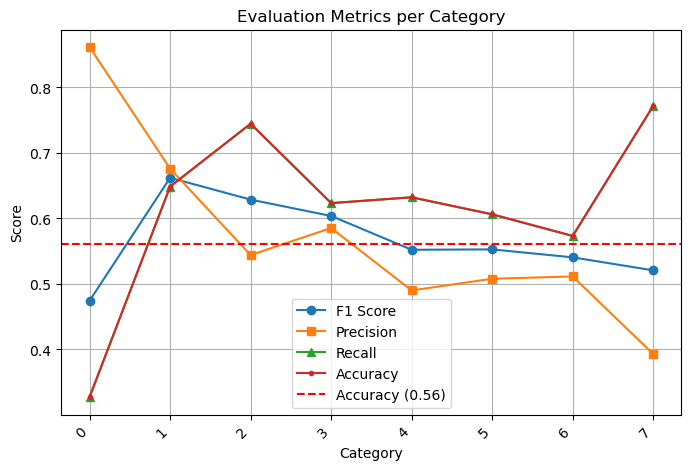

In [57]:
plot_metrics(baseline_test_accuracy, eval_perf_metrics_df)

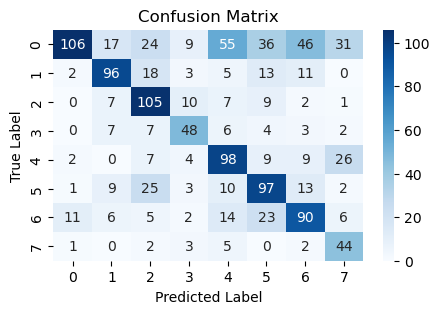

In [58]:
plot_confusion_matrix(y_test, y_pred)

## 6. **Finding the best params with a Randomized Search**

##### **Pipeline and randomized search- Details**

**Preproc functions**

In [59]:
clean_X = lambda X, threshold=20: [basic_cleaning(sentence, threshold) for sentence in X]
preproc_X = lambda X, threshold=750: [preproc(sentence, threshold) for sentence in X]

**Pipeline**

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from functools import partial

resampling_wrapper = lambda X, y=None: resampling(X, y) if y is not None else X

pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_X)),
    ('preproc', FunctionTransformer(preproc_X)),
    ('tfidf', TfidfVectorizer()),
    ('resample', FunctionTransformer(partial(resampling_wrapper))),
    ('estimator', MultinomialNB())
])

In [61]:
# debug 
# pipeline.named_steps.keys()

In [62]:
#for param, value in pipeline.get_params().items():
#    print(f"{param}: {value}")

**Params to evaluate**

In [63]:
from itertools import product

param_grid = {
    'clean__kw_args': [{"threshold": 17}], 
    'preproc__kw_args': [{"threshold": 750}],

    'tfidf__max_df' : [0.9],                             # limit high frequency words
    'tfidf__max_features': [7500],    # vocabulary size

    'estimator__n_estimators': [100, 300, 500],
    'estimator__max_depth': [3, 5, 7, 10],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.6, 0.8, 1.0],
    'estimator__colsample_bytree': [0.6, 0.8, 1.0],
    'estimator__gamma': [0, 0.1, 0.2]
}

num_configurations = len(list(product(*param_grid.values())))
grid_estimated_time = 3 * num_configurations * train_efficiency_metrics_df["metrics"].loc["total_latency_sec"]
random_estimated_time = 3 * 20 * train_efficiency_metrics_df["metrics"].loc["total_latency_sec"]

print(f"Total configurations: {num_configurations}")
print(f'Estimated time to complete with grid search : {round(grid_estimated_time, 2)} sec')
print(f'Estimated time to complete with randomized search : {round(random_estimated_time, 2)} sec')

Total configurations: 3
Estimated time to complete with grid search : 1.79 sec
Estimated time to complete with randomized search : 11.94 sec


**Search**

In [64]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
y = df['label']
le = LabelEncoder()
y_cat = le.fit_transform(y)

# Split data
X = df['quote']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)

# Run grid search
search = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_grid, 
    n_iter=20,
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1,
    random_state=42
)
search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1,
)
search.fit(X_train, y_train)

# Evaluate
print('Best parameters:')
print(search.best_params_)
print(f"\nBest accuracy: {round(search.best_score_, 3)}\n")

Best parameters:
{'clean__kw_args': {'threshold': 17}, 'estimator__alpha': 0.45, 'preproc__kw_args': {'threshold': 750}, 'tfidf__max_df': 0.9, 'tfidf__max_features': 7500}

Best accuracy: 0.543

CPU times: user 13.9 s, sys: 330 ms, total: 14.3 s
Wall time: 1min 9s


##### **Best params**

In [65]:
print('Best parameters:')
[print(f'{k}:{v}') for (k, v) in search.best_params_.items()]
print(f"\nBest accuracy: {round(search.best_score_, 3)}\n")

Best parameters:
clean__kw_args:{'threshold': 17}
estimator__alpha:0.45
preproc__kw_args:{'threshold': 750}
tfidf__max_df:0.9
tfidf__max_features:7500

Best accuracy: 0.543



## 7. **Evaluating the best model**

##### **Prepare data**

**Feature and target**

In [66]:
X = df['quote']
y = df['label']

**Encode labels**

In [67]:
# Encode labels
le = LabelEncoder()
y_cat = le.fit_transform(y)

**Clean, preproc, vectorize X**

In [68]:
X_clean = X.apply(basic_cleaning)
X_preproc = X_clean.apply(preproc)

In [69]:
search.best_params_

{'clean__kw_args': {'threshold': 17},
 'estimator__alpha': 0.45,
 'preproc__kw_args': {'threshold': 750},
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 7500}

In [70]:
tfidf_params = {k.replace("tfidf__", ""): v for k, v in search.best_params_.items() if k.startswith("tfidf__")}
tfidf_params

{'max_df': 0.9, 'max_features': 7500}

In [71]:
vectorizer = TfidfVectorizer(**tfidf_params)

X_vectorized = pd.DataFrame(
    vectorizer.fit_transform(X_preproc).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_preproc.index
)

In [72]:
print("TfidfVectorizer Parameters:", vectorizer.get_params())

TfidfVectorizer Parameters: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.9, 'max_features': 7500, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


**Split data**

In [73]:
print(pd.Series(y_cat).value_counts(normalize=True))

0    0.265638
5    0.131505
6    0.128386
4    0.127073
1    0.121655
2    0.115252
3    0.063372
7    0.047119
Name: proportion, dtype: float64


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)
print('types', type(X_train), type(X_test), type(y_train), type(y_test))
'Shapes', X_train.shape, X_test.shape, y_train.shape, y_test.shape

types <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


('Shapes', (4872, 7500), (1219, 7500), (4872,), (1219,))

In [75]:
print(pd.Series(y_train).value_counts(normalize=True))

0    0.265599
5    0.131568
6    0.128284
4    0.127053
1    0.121716
2    0.115148
3    0.063424
7    0.047209
Name: proportion, dtype: float64


In [76]:
print(pd.Series(y_test).value_counts(normalize=True))

0    0.265792
5    0.131255
6    0.128794
4    0.127153
1    0.121411
2    0.115669
3    0.063167
7    0.046760
Name: proportion, dtype: float64


**Resample training data**

In [77]:
X_resampled, y_resampled = resampling(X_train, y_train)

In [78]:
print(pd.Series(y_resampled).value_counts(normalize=True))

0    0.125
1    0.125
2    0.125
3    0.125
4    0.125
5    0.125
6    0.125
7    0.125
Name: proportion, dtype: float64


##### **Monitor best model energy consumption during training and inference - details**

**Monitor best model during training**

In [79]:
search.best_params_

{'clean__kw_args': {'threshold': 17},
 'estimator__alpha': 0.45,
 'preproc__kw_args': {'threshold': 750},
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 7500}

In [80]:
estimator_params = {k.replace("estimator__", ""): v for k, v in search.best_params_.items() if k.startswith("estimator__")}
estimator_params

{'alpha': 0.45}

In [81]:
best_model = MultinomialNB(**estimator_params)
print("MultinomialNB Parameters:", best_model.get_params())

MultinomialNB Parameters: {'alpha': 0.45, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


In [82]:
best_model, best_model_train_metrics_df = monitor_training(best_model, X_train, y_train)
print(best_model_train_metrics_df)
print()

                              metrics
total_latency_sec        1.454358e-01
sample_latency_sec       2.985136e-05
total_energy_conso_kWh   2.079898e-06
sample_energy_conso_kWh  4.269084e-10
total_emissions_kgCO₂eq  1.207048e-07



**Monitor best model during inference**

In [83]:
y_pred, best_model_inf_metrics_df = monitor_inference(best_model, X_test)

print(best_model_inf_metrics_df)
print()

                              metrics
total_latency_sec        3.742003e-02
sample_latency_sec       3.069732e-05
total_energy_conso_kWh   5.343454e-07
sample_energy_conso_kWh  4.383473e-10
total_emissions_kgCO₂eq  3.101020e-08



##### **Monitor best model energy consumption during training and inference - summary**

In [84]:
df_combined = pd.concat([train_efficiency_metrics_df, inf_efficiency_metrics_df], axis=1)
df_combined.columns = ['training', 'inference']
df_combined

,training,inference
total_latency_sec,1.989603e-01,6.663823e-02
sample_latency_sec,3.843901e-05,5.466631e-05
total_energy_conso_kWh,2.845615e-06,9.525356e-07
sample_energy_conso_kWh,5.497711e-10,7.814074e-10
total_emissions_kgCO₂eq,1.651424e-07,5.527945e-08


##### **Evaluation**

In [85]:
best_model_test_accuracy, best_model_eval_perf_metrics_df = evaluation(y_test, y_pred)

print('\nbest_model_test_accuracy:', round(best_model_test_accuracy, 3), '\n')
print('Class metrics:')
best_model_eval_perf_metrics_df.round(2)


best_model_test_accuracy: 0.56 

Class metrics:


,Category,Accuracy,Precision,Recall,F1 Score
0,0,0.81,0.47,0.81,0.60
1,1,0.60,0.72,0.60,0.65
2,2,0.65,0.60,0.65,0.62
3,3,0.29,0.92,0.29,0.44
4,4,0.45,0.54,0.45,0.49
5,5,0.55,0.61,0.55,0.58
6,6,0.35,0.65,0.35,0.45
7,7,0.07,1.00,0.07,0.13


Category distribution
                                 total  train  test  total%  train%  test%
label                                                                     
0_not_relevant                    1618    647   324    0.27    0.12   0.27
1_not_happening                    741    647   148    0.12    0.12   0.12
2_not_human                        702    647   141    0.12    0.12   0.12
3_not_bad                          386    647    77    0.06    0.12   0.06
4_solutions_harmful_unnecessary    774    647   155    0.13    0.12   0.13
5_science_unreliable               801    647   160    0.13    0.12   0.13
6_proponents_biased                782    647   157    0.13    0.12   0.13
7_fossil_fuels_needed              287    647    57    0.05    0.12   0.05

Category metrics
   Category  Accuracy  Precision  Recall  F1 Score
0         0      0.81       0.47    0.81      0.60
1         1      0.60       0.72    0.60      0.65
2         2      0.65       0.60    0.65      0.62
3     

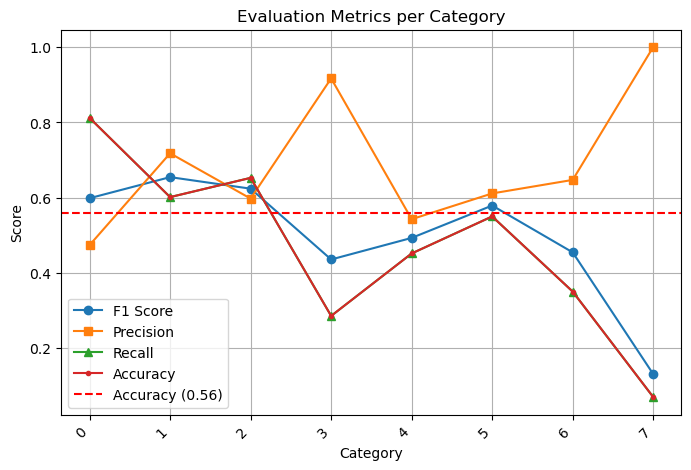

In [86]:
plot_metrics(best_model_test_accuracy, best_model_eval_perf_metrics_df)

**Confusion matrix**

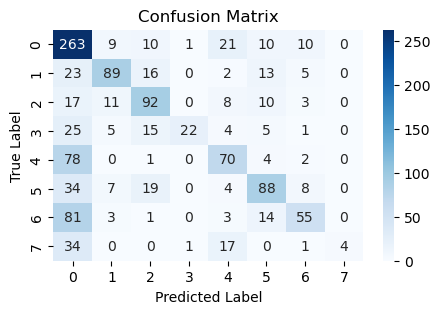

In [87]:
plot_confusion_matrix(y_test, y_pred)

## 8. **Save metadata**

In [88]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-01-30_18:21:04'

In [94]:
note = "Baseline ML, improved preproc, param search"
model_name = 'MultinomialNB'

In [95]:
filename = (
    "metrics/"
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{int(best_model_test_accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
    ".json"
)
filename

'metrics/MultinomialNB_accuracy_56_dt_20250130_182104.json'

In [96]:
import os

os.makedirs("metrics", exist_ok=True)

data = {
    "model_name": model_name,
    "timestamp": timestamp,
    "note": note,

    "baseline_test_accuracy": baseline_test_accuracy,
    "best_model_test_accuracy": best_model_test_accuracy,

    "total_training_latency_sec": train_efficiency_metrics_df['metrics'].loc['total_latency_sec'],
    "total_training_energy_conso_kWh": train_efficiency_metrics_df['metrics'].loc['total_energy_conso_kWh'],

    "total_inference_latency_sec": inf_efficiency_metrics_df['metrics'].loc['total_latency_sec'],
    "total_inference_energy_conso_kWh": inf_efficiency_metrics_df['metrics'].loc['total_energy_conso_kWh'],

    "sample_inference_latency_sec": inf_efficiency_metrics_df['metrics'].loc['sample_latency_sec'],
    "sample_inference_energy_conso_kWh": inf_efficiency_metrics_df['metrics'].loc['sample_energy_conso_kWh'],

    "train_size" : y_train.shape[0],
    "test_size" :  y_test.shape[0],
    "class_performance_metrics": eval_perf_metrics_df.to_dict(orient="records"),
    "search_best_params" : search.best_params_,
    "training_efficiency_metrics": train_efficiency_metrics_df.to_dict(orient="records"),
    "inference_efficiency_metrics": inf_efficiency_metrics_df.to_dict(orient="records")
}
data

{'model_name': 'MultinomialNB',
 'timestamp': '2025-01-30_18:21:04',
 'note': 'Baseline ML, improved preproc, param search',
 'baseline_test_accuracy': 0.561115668580804,
 'best_model_test_accuracy': 0.5602953240360952,
 'total_training_latency_sec': 0.1989603042602539,
 'total_training_energy_conso_kWh': 2.8456153141127695e-06,
 'total_inference_latency_sec': 0.06663823127746582,
 'total_inference_energy_conso_kWh': 9.525355696678163e-07,
 'sample_inference_latency_sec': 5.466630949751093e-05,
 'sample_inference_energy_conso_kWh': 7.81407358218061e-10,
 'train_size': 4872,
 'test_size': 1219,
 'class_performance_metrics': [{'Category': 0,
   'Accuracy': 0.3271604938271605,
   'Precision': 0.8617886178861789,
   'Recall': 0.3271604938271605,
   'F1 Score': 0.4742729306487696},
  {'Category': 1,
   'Accuracy': 0.6486486486486487,
   'Precision': 0.676056338028169,
   'Recall': 0.6486486486486487,
   'F1 Score': 0.6620689655172414},
  {'Category': 2,
   'Accuracy': 0.7446808510638298,
  

In [97]:
import json

with open(filename, "w") as f:
    json.dump(data, f, indent=4)

print(f"Metrics saved to {filename}")

Metrics saved to metrics/MultinomialNB_accuracy_56_dt_20250130_182104.json
